In [1]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchio as tio
import numpy as np
import pytorch_lightning as pl
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [2]:
data_path = op.join(sys.path[0], 'dataset/Experiment1/001-AR/mean_for_seg.nii.gz')

In [3]:
# data, affine = load_nifti(data_path)
# img = nib.load(data_path).get_fdata()
img = tio.ScalarImage(data_path)
img

ScalarImage(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/dataset/Experiment1/001-AR/mean_for_seg.nii.gz")

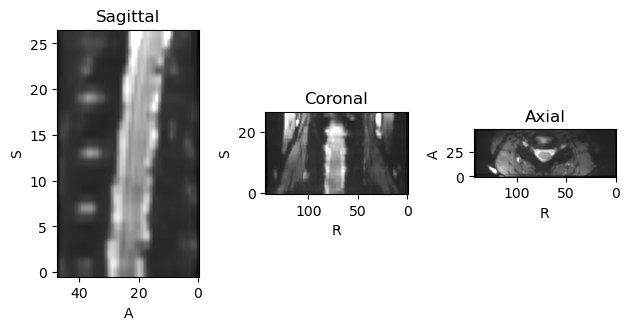

In [4]:
img.plot()

In [5]:
label_path = op.join(sys.path[0], 'dataset/Experiment1/001-AR/mask_sc.nii.gz')

In [6]:
label = tio.LabelMap(label_path)
label

LabelMap(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/dataset/Experiment1/001-AR/mask_sc.nii.gz")

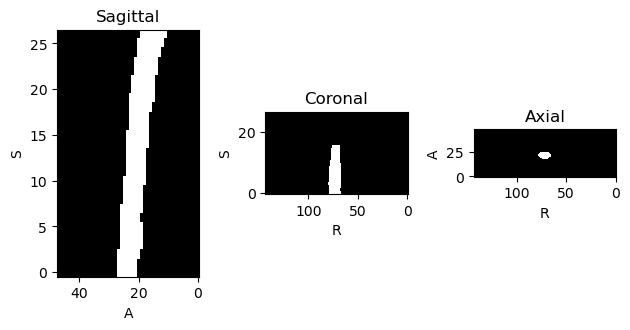

In [7]:
label.plot()

## Dataset creation

In [8]:
from torch.utils.data import Dataset

class SpinalCordDataset(Dataset):
    def __init__(self, annotations_files, img_files, transform=None, target_transform=None):
        self.img_labels = annotations_files
        self.img_files = img_files
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        image = img_file.data
        label = self.img_labels[idx].data
        if self.transform:
            image = self.transform(image).reshape(1,160,-1)
        if self.target_transform:
            label = self.target_transform(label).reshape(1,160,-1)
        return image, label

In [9]:
image_files = []
image_labels = []
test_images = []
test_labels = []

exp1_files = 12
np.random.seed(42)
indices = list(range(exp1_files))
np.random.shuffle(indices)

experiment1 = Path(op.join(sys.path[0], 'dataset/Experiment1'))
experiment2 = Path(op.join(sys.path[0], 'dataset/Experiment2'))
experiment3 = Path(op.join(sys.path[0], 'dataset/Experiment3'))

index = 0
for file_path in experiment1.iterdir():
#     print(file_path)
    for image in file_path.rglob('*seg.nii.gz'):
        if index in indices[:2]:
            test_images.append(tio.ScalarImage(image))
        else:
            image_files.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        if index in indices[:2]:
            test_labels.append(tio.ScalarImage(label))
        else:
            image_labels.append(tio.ScalarImage(label))
    index += 1

index = 0
for file_path in experiment2.iterdir():
    for image in file_path.rglob('*mean.nii.gz'):
        if index in indices[:2]:
            test_images.append(tio.ScalarImage(image))
        else:
            image_files.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        if index in indices[:2]:
            test_labels.append(tio.ScalarImage(label))
        else:
            image_labels.append(tio.ScalarImage(label))
    index += 1

index = 0
for file_path in experiment3.iterdir():
    for image in file_path.rglob('*seg.nii.gz'):
        if index in indices[:2]:
            test_images.append(tio.ScalarImage(image))
        else:
            image_files.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        if index in indices[:2]:
            test_labels.append(tio.ScalarImage(label))
        else:
            image_labels.append(tio.ScalarImage(label))
    index += 1

In [10]:
# dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((144, 48, 35)), tio.CropOrPad((144, 48, 35)))
# test_set = SpinalCordDataset(test_labels, test_images, tio.CropOrPad((144, 48, 35)), tio.CropOrPad((144, 48, 35)))
dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))
test_set = SpinalCordDataset(test_labels, test_images, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))

In [11]:
validation_split = 0.15
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [12]:
train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=16, sampler=valid_sampler)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

In [13]:
dataset[0][0].shape

torch.Size([1, 160, 2240])

In [14]:
for i, item in enumerate(train_loader):
    print('Batch {}'.format(i))
    image, label = item
    print(f"Datatype of Image: {type(image)}")
    print(f"Shape of the Image: {image.shape}")
    print(f"Label Values: {label}")
#     plt.imshow(label[0, 0,:,:,10])

Batch 0
Datatype of Image: <class 'torch.Tensor'>
Shape of the Image: torch.Size([16, 1, 160, 2240])
Label Values: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 

## Model design

In [15]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [19]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
    in_channels=1,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [20]:
loss = smpu.losses.DiceLoss()
metrics = [
    smpu.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [21]:
import segmentation_models_pytorch.utils as smpu

In [22]:
train_epoch = smpu.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smpu.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [23]:
max_score = 0

for i in range(0, 4):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 5e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                              | 0/3 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [34]:
train_logs

{'dice_loss': 0.9315088391304016, 'iou_score': 0.1488464723030726}

In [33]:
best_model = torch.load('./best_model.pth')

In [36]:
test_epoch = smpu.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 1/1 [00:01<00:00,  1.83s/it, dice_loss - 0.1049, iou_score - 0.83


In [27]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(np.swapaxes(image, 0, 1))
    plt.show()

In [29]:
for i in range(5):
    n = np.random.choice(len(test_set))
    
    image_vis = test_set[n][0].reshape(160, 64, 35)
    image, gt_mask = test_set[n]
    
    gt_mask = gt_mask.reshape(160,64,35)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round()).reshape(160,64,35)
        
    visualize(
        image=image_vis[:,:,10], 
        ground_truth_mask=gt_mask[:,:,10], 
        predicted_mask=pr_mask[:,:,10]
    )

NameError: name 'best_model' is not defined

### K-Fold

In [26]:
from sklearn.model_selection import KFold

In [27]:
k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=42)
foldperf = {}

In [28]:
num_epochs = 4
# when to decay the learning rate
epochs_to_decay = 50
reduced_lr = 1e-5

In [37]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('\nFold {}'.format(fold + 1))
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=16, sampler=val_sampler)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
        
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(val_loader)
        
        train_loss = train_logs['dice_loss']
        train_acc = train_logs['iou_score']
        val_loss = valid_logs['dice_loss']
        val_acc = valid_logs['iou_score']
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) * (fold + 1) == epochs_to_decay:
            optimizer.param_groups[0]['lr'] = reduced_lr
            print('Decrease decoder learning rate to {}!'.format(reduced_lr))
        
    foldperf['fold{}'.format(fold+1)] = history
    
torch.save(model, './k_cross.pth')    


Fold 1

Epoch: 1/4
train: 100%|█| 2/2 [00:34<00:00, 17.11s/it, dice_loss - 0.9858, iou_score - 0.00
valid: 100%|█| 1/1 [00:03<00:00,  3.47s/it, dice_loss - 0.9651, iou_score - 0.01

Epoch: 2/4
train: 100%|█| 2/2 [00:35<00:00, 17.88s/it, dice_loss - 0.9756, iou_score - 0.01
valid: 100%|█| 1/1 [00:03<00:00,  3.28s/it, dice_loss - 0.9199, iou_score - 0.06

Epoch: 3/4
train:   0%|                                              | 0/2 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [24]:
tl_f, vl_f, ta_f, va_f = [], [], [], []
for f in foldperf:
    tl_f.append(np.mean(foldperf['{}'.format(f)]['train_loss']))
    vl_f.append(np.mean(foldperf['{}'.format(f)]['val_loss']))
    ta_f.append(np.mean(foldperf['{}'.format(f)]['train_acc']))
    va_f.append(np.mean(foldperf['{}'.format(f)]['val_acc']))
    
print('Performance of {} fold cross validation'.format(k))
print('Average Training Loss: {:.3f} \t Average Val Loss: {:.3f} \t Average Training Acc: {:.2f}'
      '\t Average Val Acc: {:.2f}'.format(np.mean(tl_f), np.mean(vl_f), np.mean(ta_f), np.mean(va_f)))

Performance of 5 fold cross validation
Average Training Loss: 0.854 	 Average Val Loss: 0.879 	 Average Training Acc: 0.31	 Average Val Acc: 0.23


In [25]:
tl_over_f, vl_over_f, ta_over_f, va_over_f = [], [], [], []
for f in foldperf:
    tl_over_f.extend(foldperf['{}'.format(f)]['train_loss'])
    vl_over_f.extend(foldperf['{}'.format(f)]['val_loss'])
    ta_over_f.extend(foldperf['{}'.format(f)]['train_acc'])
    va_over_f.extend(foldperf['{}'.format(f)]['val_acc'])


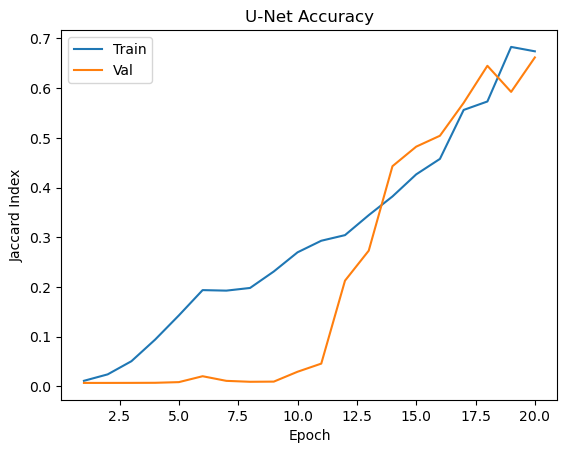

In [30]:
x_ax = np.arange(len(tl_over_f)) + 1
plt.plot(x_ax, tl_over_f, label='Train')
plt.plot(x_ax, vl_over_f, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('U-Net Loss')
plt.legend()

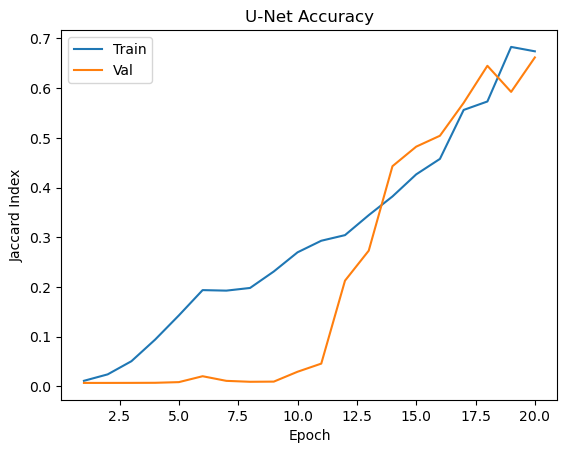

In [29]:
plt.plot(x_ax, ta_over_f, label='Train')
plt.plot(x_ax, va_over_f, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Jaccard Index')
plt.title('U-Net Accuracy')
plt.legend()

## Load model

In [24]:
created_model = torch.load('../../output3/k_cross.pth')

In [25]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 1/1 [00:07<00:00,  7.14s/it, dice_loss - 0.03807, iou_score - 0.9


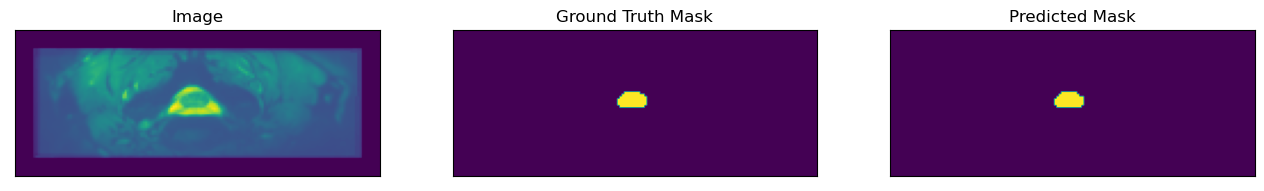

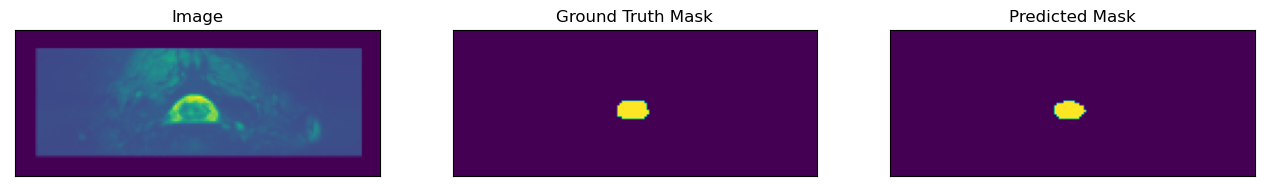

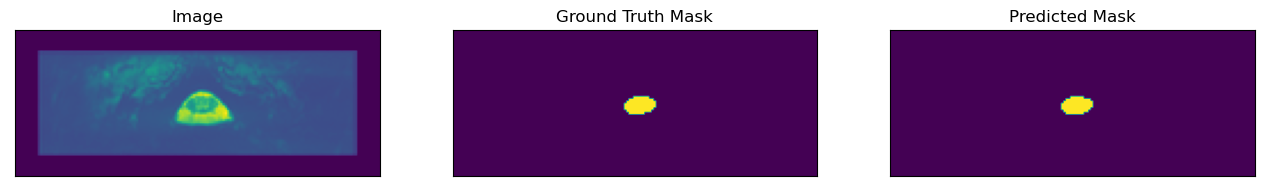

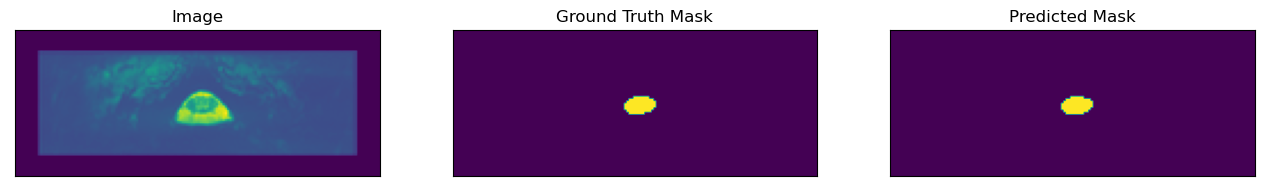

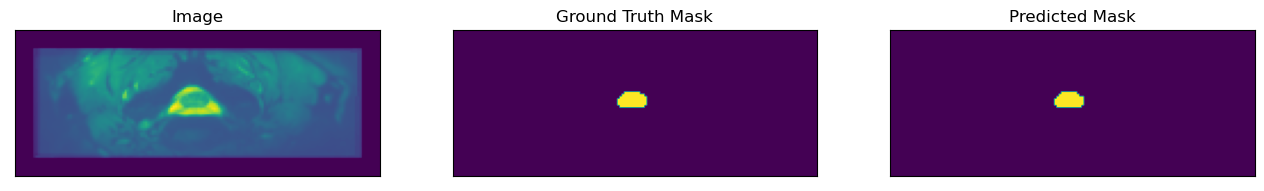

In [30]:
for i in range(5):
    n = np.random.choice(len(test_set))
    
    image_vis = test_set[n][0].reshape(160, 64, 35)
    image, gt_mask = test_set[n]
    
    gt_mask = gt_mask.reshape(160,64,35)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = created_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round()).reshape(160,64,35)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

## Legacy

In [16]:
BACKBONE = 'resnet34'

In [15]:
model = smp.Unet(
    encoder_name=BACKBONE,
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)

preprocess_input = get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [57]:
loss_func = smp.losses.DiceLoss('binary')
learning_rate = 1e-3
num_epochs = 20
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
model.train()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
# loss_0 = 0
iter_epoch = len(train_loader)
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        image, label = batch
#         print(image.shape)
        inputs = image.reshape(image.shape[0], image.shape[1], 160, -1)
        labels = label.reshape(label.shape[0], label.shape[1], 160, -1)
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss_history.append(loss.detach().numpy())
        if i % 4 == 0:
            last_4_losses = train_loss_history[-4:]
            train_loss = np.mean(last_4_losses)
            print('Iteration {} Train loss: {}'.format(i + epoch*iter_epoch, train_loss))
            
        _, preds = torch.max(outputs, 1, keepdims=True)
        targets_mask = labels >= 0
        train_acc = np.mean((preds == labels)[targets_mask].numpy())
        train_acc_history.append(train_acc)
        print('Epoch %.3f Train acc/loss: %.3f/%.3f' % (epoch + 1, train_acc, train_loss))
    
    model.eval()
    
    val_losses = []
    val_scores = []
    for image, label in val_loader:
        inputs = image.reshape(image.shape[0], image.shape[1], 160, -1)
        labels = label.reshape(label.shape[0], label.shape[1], 160, -1)
        
        outputs = model.forward(inputs)
        loss = loss_func(outputs, labels)
        
        val_losses.append(loss.detach().numpy())
        _, preds = torch.max(outputs, 1, keepdims=True)
        targets_mask = labels >= 0
        val_score = np.mean((preds == labels)[targets_mask].numpy())
        val_scores.append(val_score)
    model.train()
    val_acc = np.mean(val_scores)
    val_loss = np.mean(val_losses)
    print('Epoch {} Val acc/loss {}/{}'.format(epoch + 1, val_acc, val_loss))

Iteration 0 Train loss: 0.9834369421005249
Epoch 1.000 Train acc/loss: 0.993/0.983
Epoch 1.000 Train acc/loss: 0.993/0.983
Epoch 1.000 Train acc/loss: 0.994/0.983
Epoch 1 Val acc/loss 0.9937569754464286/0.9872865080833435
Iteration 3 Train loss: 0.974825382232666
Epoch 2.000 Train acc/loss: 0.993/0.975
Epoch 2.000 Train acc/loss: 0.993/0.975
Epoch 2.000 Train acc/loss: 0.992/0.975
Epoch 2 Val acc/loss 0.9937569754464286/0.986875057220459
Iteration 6 Train loss: 0.9634291529655457
Epoch 3.000 Train acc/loss: 0.993/0.963
Epoch 3.000 Train acc/loss: 0.993/0.963
Epoch 3.000 Train acc/loss: 0.993/0.963
Epoch 3 Val acc/loss 0.9937569754464286/0.9855778813362122
Iteration 9 Train loss: 0.957414448261261
Epoch 4.000 Train acc/loss: 0.993/0.957


KeyboardInterrupt: 

In [34]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for images, labels in dataloader:
        inputs = image.reshape(image.shape[0], image.shape[1], 160, -1)
        labels = label.reshape(label.shape[0], label.shape[1], 160, -1)
        
        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1, keepdims=True)
        targets_mask = labels >= 0
        test_scores.append(np.mean((preds.cpu() == labels.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

print(evaluate_model(model, test_loader))

0.9937569754464286


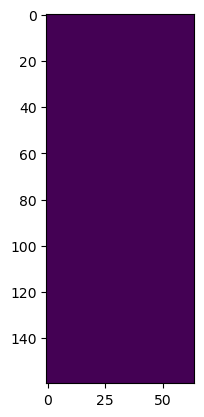

In [35]:
plt.imshow(preds[3, :, :, :].reshape(160, 64, 35).detach().numpy()[:, :, 15])

In [16]:
class UNet2DRemake:
    def __init__(self):
        self.encoder = 'resnext101_32x8d'
        self.encoder_weights = 'imagenet'
        self.activation = 'sigmoid'

        self.model = smp.Unet(encoder_name=self.encoder, encoder_weights=self.encoder_weights, classes=1,
                              activation=self.activation, in_channels=1)

    def model(self):
        return self.model()

In [23]:
model = UNet2DRemake().model

In [24]:
def divide_data(image_dimensions=(160, 64, 35)):
    """
    Splits the data into subset for training and validation and a subset for testing the model.
    :param image_dimensions: Desired dimension of images. Images are cropped/padded accordingly
    :return: Tuple of (train_val_set, test_set)
    """
    # list of images and labels
    image_files = []
    image_labels = []
    test_images = []
    test_labels = []

    # Paths of the data
    experiment1 = Path('dataset/Experiment1')
    experiment2 = Path('dataset/Experiment2')
    experiment3 = Path('dataset/Experiment3')

    # experiment 1 has the least number of participants, randomize indices to pick from each experiment two subjects for
    # testing
    exp1_files = 12
    np.random.seed(42)
    indices = list(range(exp1_files))
    np.random.shuffle(indices)

    index = 0
    for file_path in experiment1.iterdir():
        for image in file_path.rglob('*seg.nii.gz'):
            if index in indices[:2]:
                test_images.append(tio.ScalarImage(image))
            else:
                image_files.append(tio.ScalarImage(image))
        for label in file_path.rglob('*sc.nii.gz'):
            if index in indices[:2]:
                test_labels.append(tio.ScalarImage(label))
            else:
                image_labels.append(tio.ScalarImage(label))
        index += 1

    index = 0
    for file_path in experiment2.iterdir():
        for image in file_path.rglob('*mean.nii.gz'):
            if index in indices[:2]:
                test_images.append(tio.ScalarImage(image))
            else:
                image_files.append(tio.ScalarImage(image))
        for label in file_path.rglob('*sc.nii.gz'):
            if index in indices[:2]:
                test_labels.append(tio.ScalarImage(label))
            else:
                image_labels.append(tio.ScalarImage(label))
        index += 1

    index = 0
    for file_path in experiment3.iterdir():
        for image in file_path.rglob('*seg.nii.gz'):
            if index in indices[:2]:
                test_images.append(tio.ScalarImage(image))
            else:
                image_files.append(tio.ScalarImage(image))
        for label in file_path.rglob('*sc.nii.gz'):
            if index in indices[:2]:
                test_labels.append(tio.ScalarImage(label))
            else:
                image_labels.append(tio.ScalarImage(label))
        index += 1

    # Create Datasets
    dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad(image_dimensions),
                                tio.CropOrPad(image_dimensions))
    test_set = SpinalCordDataset(test_labels, test_images, tio.CropOrPad(image_dimensions),
                                 tio.CropOrPad(image_dimensions))

    return dataset, test_set

In [25]:
dataset, _ = divide_data()